<a href="https://colab.research.google.com/github/jdasam/mas1004-2022/blob/main/notebooks/Data_AI_4th_week_spiral_livecoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
from math import pi

In [ ]:
# if you run this code in your local computer, you have to check that torch is installed
!pip install torch
# But in Google Colab, torch is already installed 

In [2]:
# make spiral data
# https://gist.github.com/45deg/e731d9e7f478de134def5668324c44c5
N = 500
theta = np.sqrt(np.random.rand(N))*2*pi # np.linspace(0,2*pi,100)

r_a = 2*theta + pi
data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
x_a = data_a + np.random.randn(N,2)

r_b = -2*theta - pi
data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
x_b = data_b + np.random.randn(N,2)

res_a = np.append(x_a, np.zeros((N,1)), axis=1)
res_b = np.append(x_b, np.ones((N,1)), axis=1)

res = np.append(res_a, res_b, axis=0)
np.random.shuffle(res)

In [3]:
import matplotlib.pyplot as plt
def visualize_decision_boundary(model, data, label):
  x_linspace = torch.linspace(min(data[:,0]), max(data[:,0]), steps=200)
  y_linspace = torch.linspace(min(data[:,1]), max(data[:,1]), steps=200)
  grid_x, grid_y = torch.meshgrid(x_linspace, y_linspace)
  grid_xy = torch.stack([grid_x, grid_y]).permute(1,2,0)
  grid_xy = grid_xy.view(-1, 2)
  if isinstance(model, torch.nn.Module):
    value_by_grid = model(grid_xy)
  else:
    value_by_grid = run_neuron(model, grid_xy)
  value_by_grid = value_by_grid.view(200, 200, 1)
  value_by_grid[value_by_grid<=0.5] = 0
  value_by_grid[value_by_grid>0.5] = 1

  plt.scatter(x=data[label[:,0]==0,0], y=data[label[:,0]==0,1])
  plt.scatter(x=data[label[:,0]==1,0], y=data[label[:,0]==1,1])

  plt.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), value_by_grid.detach().numpy().squeeze(), alpha=0.3)

In [4]:
# let's convert our data in tensor
datas = torch.tensor(res, dtype=torch.float32)
# represent each number with 32 bits, instead of 64 bits

In [5]:
data_xy = datas[:, :2]
data_label= datas[:, -1]

In [7]:
data_xy.shape

torch.Size([1000, 2])

In [9]:
# make a layer with torch.nn

import torch.nn as nn # import neural net module of PyTorch

layer = nn.Linear(in_features=2, out_features=4)

# this layer has weight and bias in it
layer.weight, layer.bias

(Parameter containing:
 tensor([[ 0.1892, -0.0387],
         [ 0.2839, -0.2467],
         [ 0.6738, -0.5305],
         [-0.1355, -0.0396]], requires_grad=True), Parameter containing:
 tensor([ 0.4130, -0.4829, -0.1287, -0.0166], requires_grad=True))

In [11]:
# you can run forward propagation by just calling the layer
out = layer(data_xy) # something like torch.mm(x, self.weight) + self.bias 
out.shape


torch.Size([1000, 4])

In [13]:
layer2 = nn.Linear(in_features=4, out_features=1)
final_out = layer2(out) # this calls the forward function of nn.Linear

In [16]:
# Make an object that includes both layers
class MyModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(2, 4) # this is same as in_features=2, out_features=4
    self.layer2 = nn.Linear(4, 1)
  
  def forward(self, input_x): 
    # forward function is called when you give input to your model
    out = self.layer1(input_x)
    pred = self.layer2(out.relu())

    # this will return the prediction of our model
    # which has shape of N, 1. (N is number of data samples in input_x)
    return pred
  
model = MyModel()
pred = model(data_xy)

In [19]:
print(pred.shape, data_label.shape)
# we have to make the shape same
print(pred[:, 0].shape, data_label.shape) 
# selecting a single index from a specific dimension deletes the selected dim

torch.Size([1000, 1]) torch.Size([1000])
torch.Size([1000]) torch.Size([1000])


In [22]:
model.layer1.weight.grad # before backpropagation our parameter has no gradient

In [25]:
# nn.Module has method called parameters()
# this will make generator of every parameters in the model
for param in model.parameters():
  print(param)

Parameter containing:
tensor([[-0.2739, -0.1448],
        [-0.2201, -0.4339],
        [-0.5915, -0.4206],
        [ 0.7052,  0.5824]], requires_grad=True)
Parameter containing:
tensor([ 0.6930, -0.1668, -0.2358, -0.1119], requires_grad=True)
Parameter containing:
tensor([[-0.0599, -0.4758,  0.0980,  0.3200]], requires_grad=True)
Parameter containing:
tensor([-0.4574], requires_grad=True)


In [30]:
model = MyModel()
num_iteration = 100
lr = 1e-3 # 0.001

# save the loss record so that we can plot it
loss_record = []

# let's train our model for a given number of steps
for i in range(num_iteration):
  # get the prediction of model for the data
  pred = model(data_xy)
  loss = torch.abs(pred[:,0]-data_label)
  # loss shape would be [N] (1000)
  # each data sample has its own loss
  # we will only use the mean of those loss 
  mean_loss = loss.mean()
  mean_loss.backward() # this will add gradient for every parameters
  # that are connected to the mean loss

  # We have to update model's parameter by its gradient
  for param in model.parameters():
    # do something
    # update parameters by its gradient and learning rate
    param.data -= param.grad * lr
    param.grad = None # reset the gradient value to None
    # because the calculated gradient now became old
  
  # print(mean_loss)
  # if you want to only get the float value of a scalar tensor,
  # you can call atensor.item()
  # print(mean_loss.item())

  loss_record.append(mean_loss.item())

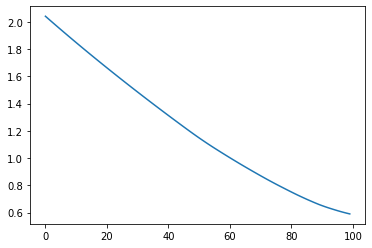

In [31]:
import matplotlib.pyplot as plt

plt.plot(loss_record)

In [24]:
model.layer1.weight.grad

tensor([[-0.1798, -0.0766],
        [-0.7708, -1.3129],
        [ 0.2760,  0.1626],
        [ 0.7259,  0.4172]])

In [34]:
# Let's do the same things with torch.optim.Optimizer

model = MyModel()
num_iteration = 300
lr = 1e-3 # 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# tell optimizer to optimize every parameters in the model

# save the loss record so that we can plot it
loss_record = []

# let's train our model for a given number of steps
for i in range(num_iteration):
  pred = model(data_xy) # make prediction 
  loss = torch.abs(pred[:,0]-data_label) # calculate loss for each sample
  mean_loss = loss.mean() # take average of loss of each sample
  # make backpropagation of loss
  mean_loss.backward() # this will add gradient for every parameters
  optimizer.step() # this will update every parameters in the optimizer (in the model)
  optimizer.zero_grad() # reset the gradient of every parameters in the optimizer

  # that are connected to the mean loss


  # # We have to update model's parameter by its gradient
  # for param in model.parameters():
  #   # do something
  #   # update parameters by its gradient and learning rate
  #   param.data -= param.grad * lr
  #   param.grad = None # reset the gradient value to None
  #   # because the calculated gradient now became old
  
  # print(mean_loss)
  # if you want to only get the float value of a scalar tensor,
  # you can call atensor.item()
  # print(mean_loss.item())

  loss_record.append(mean_loss.item())

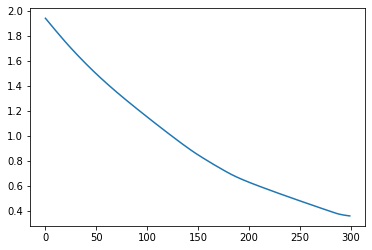

In [35]:
plt.plot(loss_record)

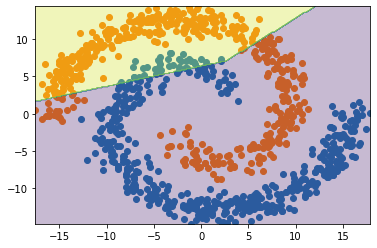

In [37]:
visualize_decision_boundary(model, data_xy, data_label.unsqueeze(1))

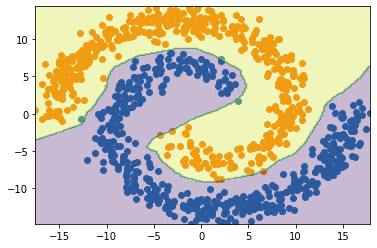

In [49]:
class MyModel(nn.Module):
  def __init__(self, hidden_size=32):
    super().__init__()
    self.layer = nn.Sequential(
        nn.Linear(2, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, 1)
    )
    # self.layer1 = nn.Linear(2, hidden_size) # this is same as in_features=2, out_features=4
    # self.layer2 = nn.Linear(hidden_size, hidden_size)
    # self.layer3 = nn.Linear(hidden_size, 1)

  def forward(self, input_x): 
    # forward function is called when you give input to your model
    # out = self.layer1(input_x)
    # pred = self.layer3(self.layer2(out.relu()).relu())

    # this will return the prediction of our model
    # which has shape of N, 1. (N is number of data samples in input_x)
    pred = self.layer(input_x)
    return pred
  
model = MyModel()

# Let's do the same things with torch.optim.Optimizer

model = MyModel()
num_iteration = 1000
lr = 1e-3 # 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# tell optimizer to optimize every parameters in the model

# save the loss record so that we can plot it
loss_record = []

# let's train our model for a given number of steps
for i in range(num_iteration):
  pred = model(data_xy) # make prediction 
  loss = torch.abs(pred[:,0]-data_label) # calculate loss for each sample
  mean_loss = loss.mean() # take average of loss of each sample
  # make backpropagation of loss
  mean_loss.backward() # this will add gradient for every parameters
  optimizer.step() # this will update every parameters in the optimizer (in the model)
  optimizer.zero_grad() # reset the gradient of every parameters in the optimizer

  # that are connected to the mean loss


  # # We have to update model's parameter by its gradient
  # for param in model.parameters():
  #   # do something
  #   # update parameters by its gradient and learning rate
  #   param.data -= param.grad * lr
  #   param.grad = None # reset the gradient value to None
  #   # because the calculated gradient now became old
  
  # print(mean_loss)
  # if you want to only get the float value of a scalar tensor,
  # you can call atensor.item()
  # print(mean_loss.item())

  loss_record.append(mean_loss.item())

visualize_decision_boundary(model, data_xy, data_label.unsqueeze(1))